# Chest X-Ray Images (Pneumonia) Detection

In [1]:
%pip install ivy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


## Introduction

This demonstration showcases the application of **Ivy**, a unified machine learning library by [Unify](https://unify.ai/), in constructing and training a classifier to identify the presence of pneumonia from chest x-ray images. The objective is to provide a comprehensive guide through the process of model training within a medical imaging context, while emphasizing the utility and versatility of Ivy.

### Notebook Structure

The notebook is organized into the following sections, mirroring the typical workflow of a machine learning project:

1. **Data Retrieval**: Acquiring the dataset necessary for training and evaluation.
2. **Data Exploration**: Conducting a preliminary analysis to understand the characteristics and distribution of the data.
3. **Data Preparation**: Preprocessing the images to facilitate effective model training.
4. **Model Creation**: Defining the architecture of the neural network to be used for classification.
5. **Model Training**: Implementing the training process, utilizing Ivy for optimization.
6. **Model Validation**: Evaluating the trained model's performance on a separate validation set.

### Training Philosophy

The primary focus of this notebook is to demonstrate the efficacy of Ivy in a practical, real-world application, rather than pushing the boundaries of model performance. Thus, we aim to train models that achieve satisfactory accuracy within a reasonable timeframe.

These thresholds were selected to balance the trade-off between accuracy and training time. The models presented herein were trained to meet these criteria within an hour, tested on a GTX1650 (locally) and a Tesla T4 GPU (on Google Colab), making the approach accessible to a wide range of users, regardless of their hardware capabilities.

Moreover, this notebook serves as a foundation for further experimentation. Users are encouraged to extend the training duration, tweak the model architectures, or employ more sophisticated models as needed, using the provided framework as a starting point for their explorations.

## Imports

In [2]:
import ivy
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, numpy as np
import matplotlib.image as mpimg
%matplotlib inline

ivy.set_backend("torch")

<module 'ivy.functional.backends.torch' from '/usr/local/lib/python3.10/dist-packages/ivy/functional/backends/torch/__init__.py'>

## Download Dataset
The [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) Kaggle dataset can be downloaded using the Kaggle API.

To download the dataset from Kaggle, you need an API key which you can obtain with a Kaggle account. You would obtain a `kaggle.json` file where you would place in the root folder in a folder named `.kaggle`.

For Google Colab users, there is a cell provided for you that allows you to upload your `kaggle.json` file and moves it to the correct directory.

Use the cells below to install `kaggle` and download the dataset. If you already have it downloaded, you can skip this step.



In [3]:
%pip install kaggle

In [4]:
# Skip this cell if you are not using google colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [5]:
import kaggle

# Ensure kaggle.json is in the proper location
kaggle.api.authenticate()

# Download the dataset
kaggle.api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', unzip=True)

## List Directories
We investigate the downloaded dataset directory `./chest_xray`.

Recall that in machine learning, we often use three datasets: training, validation, and testing.

The directory structure follows this convention.

In [6]:
data_path = './chest_xray'
os.listdir(data_path)

['val', '__MACOSX', 'train', 'chest_xray', 'test']

### Ivy's Container class
The `Container` class provided by Ivy is described as a *souped-up* version of the regular python dictionary.

To store the list of files in each subfolder, it becomes extremely convenient here.

The `train`, `test`, and `val` folders have the same directory structure, containing folders with labels:
- NORMAL - X-ray images of medical patients without pneumonia,
- PNEUMONIA - X-ray images of medical patients with pneumonia.

We create key-value pairs where the key is the label name and the value is the list of files in that subfolder with the same name as the label.

This is performed for the 3 folders, conveniently made concise with the use of Python's comprehensions and the `zip` function.

In [7]:
labels = ['NORMAL','PNEUMONIA']

file_dict = ivy.Container(
    {
        procedure : {
            k: v for k, v in zip(labels, [os.listdir(data_path+f'/{procedure}/'+label) for label in labels])
        } for procedure in ['train', 'test', 'val']
    }
)

counts = {
    k: {
        label: len(v) for label, v in file_dict[k].items()
    } for k in file_dict.keys()
}
counts

{'test': {'NORMAL': 234, 'PNEUMONIA': 390},
 'train': {'NORMAL': 1341, 'PNEUMONIA': 3875},
 'val': {'NORMAL': 8, 'PNEUMONIA': 8}}

### Addressing Imbalanced Datasets

Our dataset demonstrates a significant imbalance, with the training set containing nearly three times as many pneumonia cases as normal ones. This disparity can lead to a predictive bias in our model, where it becomes more prone to falsely identifying normal images as indicative of pneumonia.

To counteract this imbalance, several strategies can be employed:

- **Oversampling**: This involves replicating the minority class to balance the class distribution. While straightforward, this approach can lead to overfitting as the model repeatedly encounters identical samples during training, potentially memorizing rather than learning from them.

- **Undersampling**: The opposite of oversampling, this method reduces the number of samples in the majority class. A major downside is the loss of potentially crucial information, as it decreases the overall size of the training dataset.

- **Class Weighting**: This technique assigns a higher weight to the under-represented class during the loss calculation, thereby amplifying its signal and influence during model training.

Class weighting helps in enhancing the model's sensitivity to the minority class without duplicating data or discarding valuable samples. This is the approach we've implemented to address the class imbalance in our dataset, aiming to strike a balance between recognition capability and generalization.

In [8]:
normal_percent = counts['train']['NORMAL']/(counts['train']['NORMAL'] + counts['train']['PNEUMONIA'])
pneu_percent = counts['train']['PNEUMONIA']/(counts['train']['NORMAL'] + counts['train']['PNEUMONIA'])

normal_percent, pneu_percent

(0.2570935582822086, 0.7429064417177914)

In [9]:
normal_weight, pneu_weight = 4 / (normal_percent), 4 / (pneu_percent)
normal_weight, pneu_weight

(15.558538404175987, 5.384258064516129)

### Display Random Images
We explore the dataset by accessing the subfolders using the convenient `/` nesting syntax that comes with `ivy.Container`.

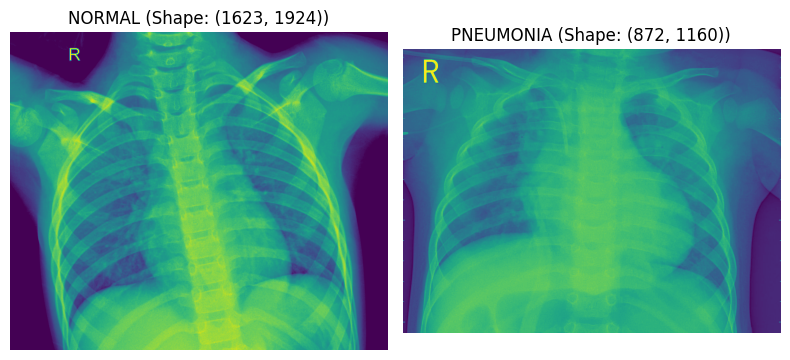

In [10]:
def display_random_images(file_dict, data_path, categories):
    fig, axs = plt.subplots(1, len(categories), figsize=(8, 5))

    for idx, category in enumerate(categories):
        # Getting the list of files for the category
        files_list = file_dict[f'train/{category}']

        # Selecting a random file
        random_file = files_list[np.random.randint(0, len(files_list))]
        img_path = f'{data_path}/train/{category}/{random_file}'

        # Loading and displaying the image
        img = mpimg.imread(img_path)
        axs[idx].imshow(img)
        axs[idx].set_title(f'{category} (Shape: {img.shape})')
        axs[idx].axis('off')  # Hide axes ticks

    plt.tight_layout()
    plt.show()

display_random_images(file_dict, data_path, labels)

## Create Dataset
As of the time of writing, Ivy itself does not provide a `Dataset` class like in other frameworks like Pytorch.

However, Ivy is designed to work with these frameworks with its backends.

We use Pytorch's `ImageFolder` class to simplify the dataset creation for us.

It requires the directory structure to be of the form:
```
- Directory
  - Category A
    - image1.jpg
    - image2.jpg
    - ...
  - Category B
      - image1.jpg
      - image2.jpg
      - ...
  -  ...
```

and so on. Thankfully, our dataset directory is already structured in this way!

In [11]:
from copy import deepcopy
from torchvision import datasets
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_datasets(data_path, train_transforms, test_transforms, val_split=0.2):
    train_data = datasets.ImageFolder(os.path.join(data_path, 'train'))
    test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transforms)

    # Get the indices
    indices = list(range(len(train_data)))

    # Get the targets
    targets = [train_data.targets[idx] for idx in indices]

    # The given validation set is too small so we decide to split the training data to produce a validation set
    train_indices, val_indices, _, _ = train_test_split(indices, targets, test_size=val_split, stratify=targets)

    # We use Subset to produce the splits with the given indices
    # We need to deepcopy to ensure that the transformations are not shared between the datasets
    val_dataset = Subset(deepcopy(train_data), val_indices)
    val_dataset.dataset.transform = test_transforms

    train_dataset = Subset(train_data, train_indices)
    train_dataset.dataset.transform = train_transforms

    return train_dataset, val_dataset, test_data

### Transforms
Ivy does not have a built-in `transforms` module like Pytorch either!

Again, even if it did, we can still use backend-specific modules as before!

We apply various transformations to ensure the data is of the same size, standardized, etc.

#### Data Augmentation
We may need to apply various augmentations in the training data to improve regularization in some cases.

We resize our images to 224x224 to be consistent with the input sizes of pretrained computer-vision models. Center cropping ensures that the most critical region, typically located at the center of medical images, is preserved. Horizontal flipping was also applied due to the human body's bilateral symmetry which does not alter the fundamental characteristics of the x-ray scans. We also apply small rotations to simulate variations in patient positioning during image capture.

Standardizing pixel values based on the mean and standard deviation of the images helps in stabilizing and speeding up training by ensuring that input features are on a similar scale. The values provided originate from ImageNet, a commonly used dataset in computer-vision research.

In [12]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [13]:
# Create the datasets with the desired transforms
train_data, val_data, test_data = get_datasets(data_path, train_transforms, test_transforms)
len(train_data), len(val_data), len(test_data)

(4172, 1044, 624)

### IvyDataset
We want our dataset to be backend-agnostic if we want to use another backend (other than `torch`).

This can be achieved by wrapping around the `Dataset` module and ensuring that we always return `ivy.array` when fetching items.

We make a custom `IvyDataset` class for this, and define the `__getitem__` method exactly as described.

In [14]:
from torch import tensor
from torch.utils.data import Dataset

class IvyDataset:
    def __init__(self, dataset: Dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        # Convert the data to ivy.Array
        x_ivy = ivy.array(x)
        y_ivy = ivy.array(tensor(y))
        return x_ivy, y_ivy

#### Important Considerations
`ImageFolder` is derived from `Dataset`, where the targets are automatically mapped to integer indices so NORMAL and PNEUMONIA images might be labelled 0 and 1 respectively.

However, the targets are `int` must be converted to a `tensor` so we can wrap `ivy.array` around it.

We now have `ivy.array` items with the transforms applied, since `ImageFolder` applies the transforms whenever accessing the dataset!

In [15]:
train_data = IvyDataset(train_data)
test_data = IvyDataset(test_data)

# check if the data adds up
len(train_data), len(test_data)

(4172, 624)

In [16]:
x, y = train_data[0]
x.shape, y # x should be (3, 28, 28) and y should be a scalar

(ivy.Shape(3, 224, 224), ivy.array(1))

## DataLoaders
We want to process the dataset in batches and also sample them randomly, so we create an `IvyDataLoader` class that functions similarly to Pytorch's `DataLoader`.

We also add multiprocessing functionality to speed up data retrieval. You may experiment with `num_workers` to determine what works the fastest with your hardware setup.

In [17]:
from concurrent.futures import ThreadPoolExecutor

class IvyDataLoader:
    def __init__(self, dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=4):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.num_workers = num_workers

    def __iter__(self):
        self.idx = 0
        self.indices = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(self.indices)
        if self.num_workers > 0:
            self.executor = ThreadPoolExecutor(max_workers=self.num_workers)
        else:
            self.executor = None
        return self

    def __next__(self):
        if self.idx >= len(self.dataset):
            if self.executor:
                self.executor.shutdown()
            raise StopIteration

        indices = self.indices[self.idx:self.idx + self.batch_size]

        if self.executor:
            batch = list(self.executor.map(lambda i: self.dataset[i], indices))
        else:
            batch = [self.dataset[i] for i in indices]

        batch_x, batch_y = zip(*batch)
        batch_x_ivy = ivy.concat([ivy.expand_dims(x, axis=0) for x in batch_x], axis=0)
        batch_y_ivy = ivy.array(batch_y)
        self.idx += self.batch_size

        if len(batch_x_ivy) < self.batch_size and self.drop_last:
            raise StopIteration

        return batch_x_ivy, batch_y_ivy

    def __len__(self):
        if self.drop_last:
            return len(self.dataset) // self.batch_size
        else:
            return (len(self.dataset) + self.batch_size - 1) // self.batch_size

In [18]:
np.random.seed(42)

num_workers = os.cpu_count()/4

train_loader = IvyDataLoader(train_data, batch_size=32, shuffle=True, num_workers=num_workers)
test_loader = IvyDataLoader(test_data, batch_size=32, shuffle=False, num_workers=num_workers)

In [19]:
len(train_loader), len(test_loader)

(131, 20)

In [ ]:
# This will be slower on the first run because there is an initial overhead from starting each thread
# %timeit -n 10 -r 3 next(iter(train_loader))

In [20]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape # (batch_size, 3, 224, 224) (batch_size)

(ivy.Shape(32, 3, 224, 224), ivy.Shape(32))

### Show Batch
An convenience function `show_batch` was created which allows us to display a batch of data so that we can see the transformed data.

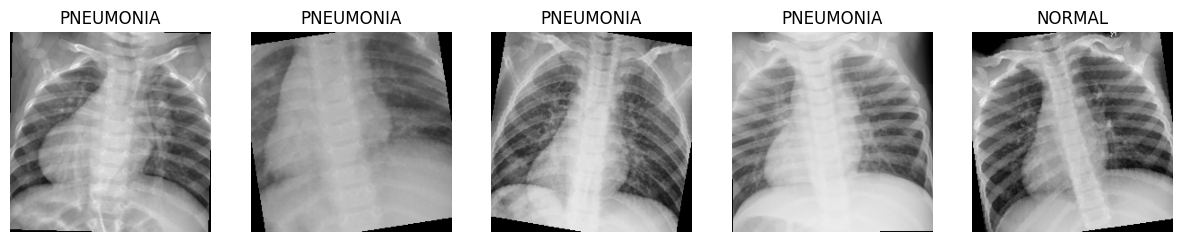

In [21]:
def show_batch(dls, class_names, num_images=5):
    x_batch, y_batch = next(iter(dls))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        # Convert ivy.Array back to numpy for plotting
        img = ivy.to_numpy(x_batch[i])
        label = ivy.to_numpy(y_batch[i])

        # Transpose the image dimensions from (C, H, W) to (H, W, C)
        img = img.transpose((1, 2, 0))

        # Undo the normalization for display purposes
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.show()

show_batch(train_loader, labels)

## Device
From here onwards, we want to start using the gpu if possible to accelerate our training.

We can simply use `ivy.set_default_device` and `ivy.set_soft_device_mode` which would skip the process entirely of needing to use `to_device` (like Pytorch's `to`) everytime we want to use data to the target device.

In [22]:
device = "gpu:0" if ivy.device.gpu_is_available() else "cpu"
ivy.set_default_device(device)
ivy.set_soft_device_mode(True)

### Refactoring
If we want to change our transforms, we have to call `get_datasets` again, create an `IvyDataset` and then `IvyDataLoader`.

We can simplify this process by combining everything into one function call.

In [23]:
def create_dls(data_path, train_transforms, test_transforms, batch_size, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    if isinstance(batch_size, list) and len(batch_size) != 3:
        raise ValueError("batch_size must be a single integer or a list of 3 integers.")

    # If batch_size is a list of 3:
    if isinstance(batch_size, list):
        train_batch_size = batch_size[0]
        val_batch_size = batch_size[1]
        test_batch_size = batch_size[2]
    else:
        train_batch_size = batch_size
        val_batch_size = batch_size
        test_batch_size = batch_size

    # Create Datasets
    train_data, val_data, test_data = get_datasets(data_path, train_transforms, test_transforms)

    # Create IvyDataLoaders
    train_loader = IvyDataLoader(IvyDataset(train_data), batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
    val_loader = IvyDataLoader(IvyDataset(val_data), batch_size=val_batch_size, shuffle=False, num_workers=num_workers)
    test_loader = IvyDataLoader(IvyDataset(test_data), batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dls(data_path, train_transforms, test_transforms, 32, random_seed=42)
xb, yb = next(iter(train_loader))

## Model

We will train a classifier using Ivy by building a simple CNN (*convolutional neural network*). We can build models by subclassing the `ivy.Module` class, which functions similarly to PyTorch's `nn.Module`.

**Key Components:**

* **Convolutional Layers:** Extract features with learned filters.  Kernel size, stride, and padding determine the output dimensions.
* **Pooling Layers:** Reduce dimensionality by summarizing regions (here, max pooling takes the maximum value in each region). This helps focus on more general features.
* **Batch Normalization:** Improves training stability and speed by normalizing activations within each batch.
* **Dropout:**  Randomly turns off neurons during training to prevent the network from overfitting to the training data.
* **Fully Connected Layer:** Learns how to combine features for classification from the flattened output of the convolutional layers.

In [24]:
class CNN(ivy.Module):
    def __init__(self, in_channels, dropout_rate=0.5, data_format="NCHW"):
        self.in_channels = in_channels
        self.data_format = data_format
        self.dropout_rate = dropout_rate
        super().__init__()

    def _build(self, *args, **kwargs):
        self.conv1 = ivy.Sequential(
            ivy.Conv2D(self.in_channels, 4, [3, 3], [2, 2], 1, data_format = self.data_format, with_bias=False),
            ivy.BatchNorm2D(4, data_format=self.data_format),
            ivy.ReLU()
        ) # 112 x 112

        self.pool1 = ivy.MaxPool2D([2, 2], 2, 0, data_format=self.data_format)  # Output: 56 x 56

        self.conv2 = ivy.Sequential(
            ivy.Conv2D(4, 8, [3, 3], [2, 2], 1, data_format = self.data_format, with_bias=False),
            ivy.BatchNorm2D(8, data_format=self.data_format),
            ivy.ReLU()
        ) # 28 x 28

        self.pool2 = ivy.MaxPool2D([2, 2], 2, 0, data_format=self.data_format)  # Output: 14 x 14

        self.lin1 = ivy.Sequential(
            ivy.Linear(8*14*14, 16),
            ivy.ReLU()
        )

        self.classifier = ivy.Linear(16, 1)

    def _forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.lin1(x.reshape((-1, 8*14*14)))
        x = ivy.dropout(x, self.dropout_rate, training=self.training) # dropout after linear layer to improve regularization
        x = self.classifier(x).squeeze(axis=-1)
        return x.sigmoid() # output probability

In [25]:
model = CNN(3)
model.eval()
# Check the output shapes
model(xb).shape, yb.shape

(ivy.Shape(32), ivy.Shape(32))

## Inference
The model performs a forward pass on the input images and produces a sigmoid output. This sigmoid output represents the probability of an image belonging to the pneumonia class. To obtain the final classification, we compare the sigmoid output against a predefined threshold.

The `ivy.where` function is employed to obtain our predictions based on this threshold. If the sigmoid output exceeds the threshold, the image is classified as pneumonia; otherwise, it is classified as normal. Initially, we set the probability threshold to 0.5, which is a common starting value for binary classification tasks.

In [26]:
probs = model(xb)
class_predictions = ivy.where(probs > 0.5, 1, 0)
class_predictions, yb

(ivy.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dev=gpu:0),
 ivy.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dev=gpu:0))

### Accuracy Metric
To evaluate the model's performance, we calculate the accuracy by counting the number of correct predictions and dividing it by the total number of elements in the batch. The accuracy metric provides a straightforward measure of how well the model is performing on the given data.

In [27]:
(class_predictions == yb).sum() / len(yb)

ivy.array(0.09375, dev=gpu:0)

In [28]:
def accuracy(probs, labels):
    return (ivy.where(probs > 0.5, 1, 0) == labels).sum().to_scalar() / len(labels)

In [29]:
accuracy(probs, yb)

0.09375

## Training
### Loss Function
The binary cross-entropy loss is a commonly used loss function for binary classification problems, where the goal is to predict whether an input belongs to one of two classes (in our case, either "pneumonia" or "normal").

To counteract this class imbalance issue mentioned from earlier, we introduce class weights in our loss function.

The `weighted_binary_cross_entropy` function calculates the weighted binary cross-entropy loss by assigning different weights to the positive (pneumonia) and negative (normal) classes. The `pos_weight` and `neg_weight` parameters control the relative importance of each class during training.

By assigning a higher weight to the underrepresented class (normal cases), the model is encouraged to pay more attention to correctly classifying the minority class examples. This helps to balance the contribution of each class to the overall loss, mitigating the impact of class imbalance on the model's performance.

In [30]:
def weighted_binary_cross_entropy(true_labels, predictions, pos_weight, neg_weight, eps=1e-5):
    predictions = predictions.clip(eps, 1-eps)
    loss_pos = -pos_weight * true_labels * ivy.log(predictions)
    loss_neg = -neg_weight * (1 - true_labels) * ivy.log(1 - predictions)
    return (loss_pos + loss_neg).mean()

weighted_binary_cross_entropy(yb, probs, pneu_weight, normal_weight)

ivy.array(6.59772226, dev=gpu:0)

In [31]:
def loss_fn(params):
    v, model, x, y = params
    probs = model(x, v=v)
    return weighted_binary_cross_entropy(y, probs, pneu_weight, normal_weight)

In [32]:
loss_fn((None, model, xb, yb))

ivy.array(6.59772226, dev=gpu:0)

### Training and Validation
The `train_step` function performs a forward pass on the input data (`xb`) using the provided model, calculates the loss and gradients using the `loss_fn`, updates the model's parameters using the optimizer, and returns the loss and accuracy for the current batch.

The `test_step` function is similar to `train_step`, but it only calculates the loss and accuracy without updating the model's parameters, as it's used for evaluation purposes.

In [33]:
def train_step(xb, yb, model, optimizer):
    probs = model(xb)
    loss, grads = ivy.execute_with_gradients(
        loss_fn,
        (model.v, model, xb, yb)
    )

    model.v = optimizer.step(model.v, grads)

    return loss.to_scalar(), accuracy(probs, yb)

def test_step(xb, yb, model):
    probs = model(xb)
    loss = loss_fn((None, model, xb, yb))

    return loss.to_scalar(), accuracy(probs, yb)

### Model Fitting
The `fit` function runs the training and validation loops over multiple epochs. It uses a dictionary `results` to store the training and validation metrics (loss and accuracy) for each epoch.

In each epoch, the function initializes variables to accumulate the total loss and accuracy for both training and validation sets. It uses a unified progress bar (`tqdm`) to display the current epoch, loss, and accuracy during training and validation.

To account for specific layers that function differently during training and evaluation (e.g., dropout), we use `model.train()` and `model.eval()` to switch between modes. `ivy.Module` (the class our model inherits from) uses these functions to control a `training` flag to achieve this intended purpose.

After completing both training and validation phases, the function calculates the average loss and accuracy for the epoch by dividing the accumulated metrics by the total number of samples. These average metrics are then appended to the `results` dictionary and displayed in the progress bar.

In [34]:
def fit(epochs, train_dls, val_dls, model, optimizer, results):
    if not results:
        # Initialize results dictionary
        results = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Calculate total steps per epoch (train + test batches)
    total_steps_per_epoch = len(train_dls) + len(val_dls)

    try:
        for epoch in range(epochs):
            # Initialize metrics
            total_train_loss = 0.0
            total_train_acc = 0.0
            total_val_loss = 0.0
            total_val_acc = 0.0

            # Unified progress bar for both training and testing
            unified_loop = tqdm(range(total_steps_per_epoch), desc=f'Epoch {epoch + 1}/{epochs}', leave=True, position=0)

            # Training phase
            model.train()
            for xb, yb in train_dls:
                train_loss, train_accuracy = train_step(xb, yb, model, optimizer)
                total_train_loss += (train_loss * xb.shape[0])
                total_train_acc += train_accuracy

                unified_loop.set_postfix_str(f"(Train) loss: {train_loss:.4f}, acc: {train_accuracy:.4f}")
                unified_loop.update(1)  # Update progress after each training batch

            # Testing phase
            model.eval()
            for xb, yb in val_dls:
                val_loss, val_accuracy = test_step(xb, yb, model)
                total_val_loss += (val_loss * xb.shape[0])
                total_val_acc += val_accuracy

                unified_loop.set_postfix_str(f"(Val) loss: {val_loss:.4f}, acc: {val_accuracy:.4f}")
                unified_loop.update(1)  # Update progress after each test batch

            # Calculate average metrics for the epoch
            avg_train_loss = total_train_loss / (len(train_dls) * train_dls.batch_size)
            avg_train_acc = total_train_acc / len(train_dls)
            avg_val_loss = total_val_loss / (len(val_dls) * val_dls.batch_size)
            avg_val_acc = total_val_acc / len(val_dls)

            # Update results and progress bar postfix
            results['train_loss'].append(avg_train_loss)
            results['train_acc'].append(avg_train_acc)
            results['val_loss'].append(avg_val_loss)
            results['val_acc'].append(avg_val_acc)

            unified_loop.set_postfix(train_loss=avg_train_loss, train_acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc)
    except KeyboardInterrupt:
        # Catch the keyboard interrupt and exit the training loop gracefully
        print(f"\nTraining interrupted at epoch {epoch+1}.")
    finally:
        print(f"Training completed at epoch {epoch+1}.")

    return results

In [35]:
def plot_training_results(results):
    epochs = range(1, len(results['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results['train_loss'], label='Training Loss')
    plt.plot(epochs, results['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results['train_acc'], label='Training Accuracy')
    plt.plot(epochs, results['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [36]:
results = {}
optimizer = ivy.AdamW(lr=1e-3, weight_decay=1e-2) # We use AdamW for fast learning and a high weight decay to improve regularization

In [37]:
num_epochs = 5
results = fit(num_epochs, train_loader, val_loader, model, optimizer, results)

Epoch 1/5:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/164 [00:00<?, ?it/s]

Training completed at epoch 5.


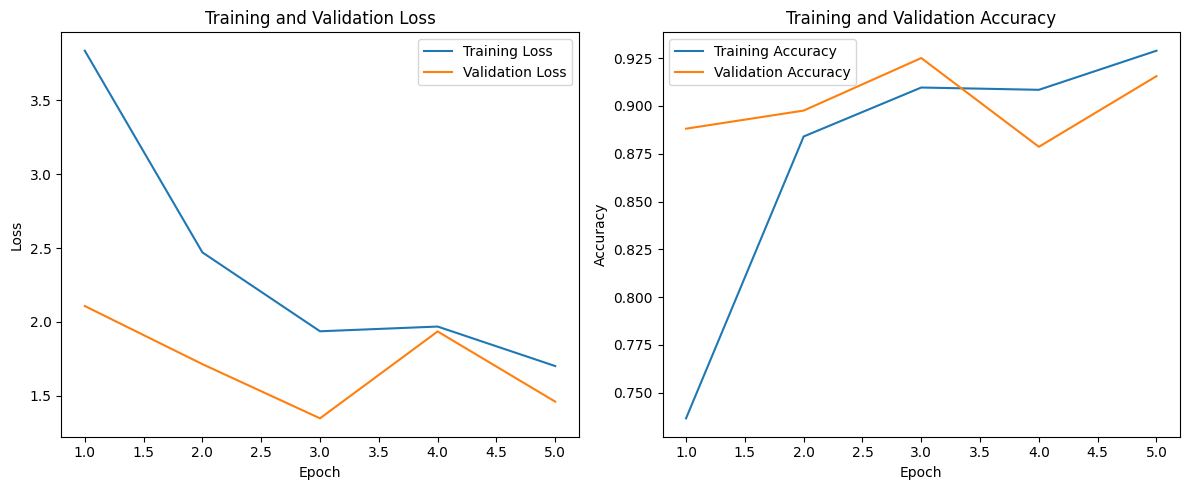

In [38]:
plot_training_results(results)

### Saving our Trained Model

An `ivy.Module` object contains the trained weights stored in its `v` property. It is an `ivy.Container` object, which provides various methods for saving the data to disk.

We can save our trained model using different output formats. In this case, we are using the 'hdf5' format by invoking the `cont_to_disk_as_hdf5` method.

The 'w' mode is specified as the argument, so that the weights can be overwritten if the file already exists; otherwise, the file will be created if it does not exist.

In [39]:
model.v.cont_to_disk_as_hdf5('your_weights.hdf5', mode='w')

### Loading our Model
To load our pre-trained model, we utilize the `cont_to_disk_as_hdf5` method, which allows us to directly assign the pre-trained weights to the `.v` property of an `ivy.Module` object, such as a CNN.

For convenience, we provide a default weights file named `weights.hdf5`. This file can be used if you have not performed the training steps and wish to use a model that has already been trained.

Before loading the weights into the model, ensure that the model is in evaluation mode. This is an important step as it disables layers like dropout, and ensures that batch normalization layers use the running means and standard deviations from the training phase, replicating the exact state of the saved model.

In [40]:
loaded = ivy.Container.cont_from_disk_as_hdf5('weights.hdf5')

loaded_model = CNN(3)
loaded_model.eval()
loaded_model.v = loaded

/usr/local/lib/python3.10/dist-packages/ivy/functional/backends/torch/creation.py:131: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  ret = torch.as_tensor(obj, dtype=dtype, device=device)


## Model Evaluation

We'll use a classification report and a confusion matrix to evaluate our model's performance. These provide a clear picture of how well it classifies data.

### Classification Report

A classification report includes several metrics, such as precision, recall, F1-score, and support for each class. This report is converted to a pandas DataFrame for better readability and potential further analysis.

### Confusion Matrix

A confusion matrix shows how our model's predictions fall into these categories:

* **True Positives:** Correctly predicted positive cases
* **False Positives:** Incorrectly predicted positive cases
* **True Negatives:** Correctly predicted negative cases
* **False Negatives:** Incorrectly predicted negative cases

This helps us see where the model might be making mistakes.

### Threshold Optimization

Our model uses a threshold to decide when a predicted probability counts as a positive classification. The default threshold is 0.5, but this can be adjusted. After testing, we determined that a threshold of 0.45 works best for our specific model and dataset by achieving the best overall results.  

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

def evaluate_model(model, test_loader, threshold=0.5):
    all_preds = []
    all_labels = []

    # Ensure the threshold is between 0 and 1
    if not 0 <= threshold <= 1:
        raise ValueError("Threshold must be between 0 and 1")

    # Loop over the entire test dataset
    for xb, yb in test_loader:
        # Generate predictions using the provided model and threshold
        probs = model(xb)
        preds = ivy.where(probs > threshold, 1, 0)
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())

    # Convert lists to a NumPy array for confusion matrix computation
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate a classification report
    report = classification_report(all_labels, all_preds, output_dict=True)

    # Convert the report to a pandas DataFrame
    df_report = pd.DataFrame(report).transpose()

    return cm, df_report

cm, df_report = evaluate_model(loaded_model, test_loader, 0.45)

In [42]:
df_report

,precision,recall,f1-score,support
0,0.735426,0.700855,0.717724,234.000000
1,0.825436,0.848718,0.836915,390.000000
accuracy,0.793269,0.793269,0.793269,0.793269
macro avg,0.780431,0.774786,0.777320,624.000000
weighted avg,0.791683,0.793269,0.792219,624.000000


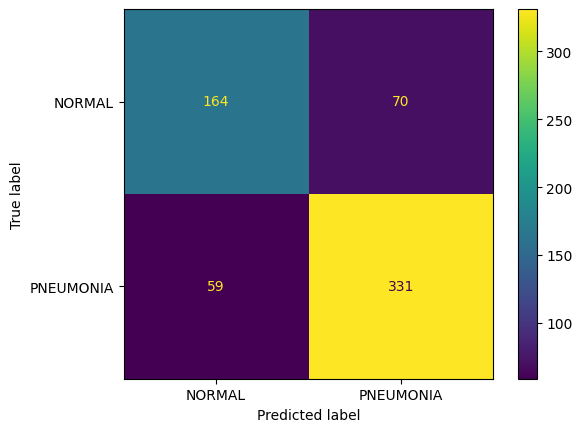

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm, display_labels=labels).plot();

## Areas for Improvement
Our dataset is imbalanced, with more pneumonia cases than normal. This can make it harder for the model to learn to recognize the less common class.  While getting more data is always ideal but not feasible for this demonstration, here are some strategies to try:

**Potential Solutions**

* **Oversampling the Minority Class:**  Increase the number of normal cases in the training set. Care must be taken to ensure that the training and validation splits are done in a way that prevents data leakage.

* **Explore More Complex Architectures:** If you have the computational resources, try a more powerful model architecture like a Vision Transformer (ViT). Their attention mechanisms might help them learn more complex patterns.

* **Transfer Learning:** Train the model on a large, pre-trained image classification model like a ResNet or VGG. This can leverage the knowledge learned from a broader dataset and potentially improve performance, especially with limited data.

* **Ensemble Methods:** Combine the predictions of multiple models. This often gives better results than a single model, but can make your system more complex.